<p style="font-family: Verdana; letter-spacing: 2px; color:#000000; font-size:300%; padding: 0px; text-align:center;"><b>Introduction to Solving the Traveling Salesman Problem</b></p>
    
The Traveling Salesman Problem (TSP) is a classic optimization problem that has captivated mathematicians, computer scientists, and operations researchers for decades. The problem is deceptively simple to state: given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city? Despite its simple description, TSP is known for its computational complexity and has become a benchmark for evaluating optimization algorithms.
    
The TSP is not just a theoretical problem but has practical applications in various fields such as logistics, manufacturing, transportation, and even DNA sequencing. Efficiently solving the TSP can lead to significant cost savings and operational efficiencies in these domains. However, the TSP is classified as an NP-hard problem, meaning that as the number of cities increases, the problem becomes exponentially harder to solve. This has led to extensive research into approximation algorithms and heuristic methods that can provide good, if not always optimal, solutions in a reasonable time frame.
    
# Objectives of This Notebook
In this notebook, we will explore various methods to solve the Traveling Salesman Problem. We will:

- Implement and compare different algorithms for solving TSP.
- Analyze the performance and efficiency of each approach.
- Demonstrate the use of Python libraries and tools to solve TSP efficiently.

By the end of this notebook, you will have a comprehensive understanding of the Traveling Salesman Problem and the techniques available to solve it, along with practical implementations that you can apply to real-world problems.

# Intro

A variety of heuristic and exact methods are available for solving the traveling salesman problem. Before the procedure can be started, it must be represented by a simple model. This is done using a graph.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Weighted_K4.svg/600px-Weighted_K4.svg.png)

The diagram above shows such a graph. The nodes $i=A,B,C,D$ represent the cities to be visited. The undirected edges $(i,j)$ show the connection between the cities. For each edge there are costs, time or path lengths $c_{ij}$ which are incurred using this route. These costs or times must be minimized. Each node may only be accessed once ([Hamiltonian path](https://en.wikipedia.org/wiki/Hamiltonian_path)). 

In the graph above, the edge values are the distance in kilometers. So if you want to get from city A to city B, you have to travel a total of 20 km.

The graph above is called a complete graph because all nodes have a direct connection to the other nodes. But what if there is a highway closure, roadwork or a mission connection, for example so that city D is only reachable from city A or B **but not** from city C? Then is graph is called to be an incomplete path. If we have to work with an incomplete graph we will introduce an edge with the edge score $c_{i,j}=\infty$ to the missing edge. Due to the long length and the goal of minimization such an edge is never included in the shortest tour. 

The graph has undirected edges. Undirected edges mean that the edge length from one node to the other is identical in both directions. This is also refered to as a **symmetric TSP**. In an asymmetric TSP, on the other hand, the edge length from one node to the other is not identical in both directions. 

Here is an example:

The distance betweeen two cities is 112 km due to some construction sites and closures on the highway and the associated detour. This detour leads to a longer route. The return journey, on the other hand, is free of roadworks and closures and can be made entirely on the highway. The return journey is therefore shorter here. 

# Approaches to Solving TSP
Given the complexity of TSP, several approaches have been developed to tackle the problem. These can be broadly classified into exact and neuristic or metaheuristic algorithms. 

## Exact Algorithms
1. **Brute Force Method:** This method involves calculating the total distance for every possible permutation of cities. While it guarantees the optimal solution, it is computationally infeasible for large numbers of cities due to factorial growth in the number of permutations.
2. **Dynamic-Programming:** The Held-Karp algorithm is a well-known dynamic programming approach that reduces the time complexity compared to brute force, but it is still impractical for very large instances.
3. **Branch and Bound:** This technique systematically explores the solution space, pruning branches that cannot yield a better solution than the current best. It can solve moderately sized instances more efficiently than brute force but is still limited by exponential time complexity in the worst case.

## Heuristic and Metaheuristic Algorithms
1. **Greedy Algorithm:** A simple and fast approach that builds a route by repeatedly selecting the nearest unvisited city. While not guaranteed to find the optimal solution, it can provide good solutions quickly for small to medium-sized problems.
2. **Genetic Algorithms:**  Inspired by natural selection, these algorithms use crossover and mutation operations on a population of routes to evolve better solutions over successive generations.
3. **Simulated Annealing:** This probabilistic technique searches for a better solution by exploring neighbors of the current solution and occasionally accepting worse solutions to escape local optima.
4. **Ant Colony Optimization:** This algorithm mimics the behavior of ants searching for food, where simulated ants lay down pheromones on paths that lead to better solutions, thus guiding future searches.


## Which algorithm I should use?
Choosing the appropriate approach to solve TSP depends highly on the number of cities (n). Here is a general rule of thumbs for different ranges of n:

- **n ≤ 20:** Exact algorithms (e.g. brute force).
- **20 < n ≤ 100:** ILP, Branch and Bound, simple heuristics.
- **100 < n ≤ 1000:** Metaheuristics (Genetic Algorithms, Simulated Annealing), Christofides' Algorithm.
- **n > 1000:** Advanced metaheuristics, clustering techniques, parallel computing

In [1]:
import pandas as pd
import numpy as np
import random
from sys import maxsize 
import matplotlib.cm as cm
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import distance_matrix
import plotly.graph_objects as go

In [2]:
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace";

In [3]:
tiny = pd.read_csv('/kaggle/input/traveling-salesman-problem/tiny.csv', names=['A', 'B'], header=None)
small = pd.read_csv('/kaggle/input/traveling-salesman-problem/small.csv', names=['A', 'B'], header=None)
medium = pd.read_csv('/kaggle/input/traveling-salesman-problem/medium.csv', names=['A', 'B'], header=None)
large = pd.read_csv('/kaggle/input/traveling-salesman-problem/large.csv', names=['A', 'B'], header=None)

# Plot Cities
Before we start let´s quickly create 4 diagrams plotting the coordinates. 

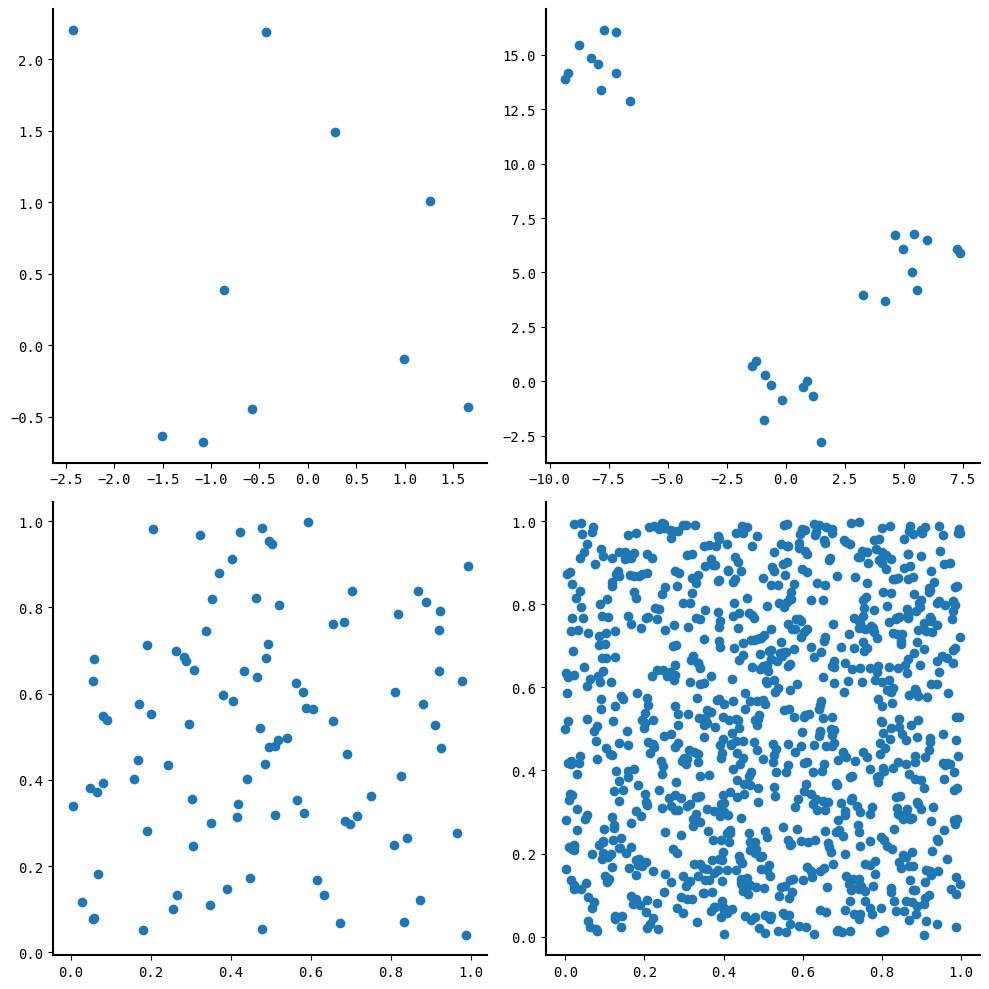

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(tiny['A'], tiny['B'])
axs[0, 1].scatter(small['A'], small['B'])
axs[1, 0].scatter(medium['A'], medium['B'])
axs[1, 1].scatter(large['A'], large['B'])
plt.tight_layout()
plt.show()

# Tiny City
## Brute Force 

Let´s start with a very easy example and use the `tiny` dataset. The most direct solution would be to try all permutations and see which one is the cheapest. Because the dataset is very small we can use this appraoch. The running time for this lies within a polynomial factor of $O(n!)$.

In [5]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

In [6]:
%%time
coordinates = tiny[['A', 'B']].values.tolist()
distances = [[distance(p1, p2) for p2 in coordinates] for p1 in coordinates]

n = len(coordinates)
all_permutations = itertools.permutations(range(n))
best_path = None
min_distance = float('inf')

for path in all_permutations:
    total_distance = sum(distances[path[i]][path[i+1]] for i in range(n-1))
    total_distance += distances[path[n-1]][path[0]]
    
    if total_distance < min_distance:
        min_distance = total_distance
        best_path = path
print("Best path:", best_path)
print("Minimum distance:", min_distance)

Best path: (6, 7, 2, 8, 5, 1, 4, 0, 3, 9)
Minimum distance: 12.516978039789695
CPU times: user 18.1 s, sys: 5.86 ms, total: 18.1 s
Wall time: 18.1 s


It took us around 18 seconds to find the best path. With just 10 datapoints this is extremely slow. Nevertheless let´s show the shortest path between the data points. 

In [7]:
def print_best_route(best_path):
    plt.figure(figsize=(8,8))
    for i, index in enumerate(best_path):
        x, y = coordinates[index]
        plt.text(x, y, str(i+1), fontsize=12, color='black', ha='right', va='top')
    plt.plot([coordinates[i][0] for i in best_path], [coordinates[i][1] for i in best_path], 'ro-')
    plt.plot([coordinates[best_path[-1]][0], coordinates[best_path[0]][0]], [coordinates[best_path[-1]][1], coordinates[best_path[0]][1]], 'ro-')
    plt.title('Best Path for the Salesman')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

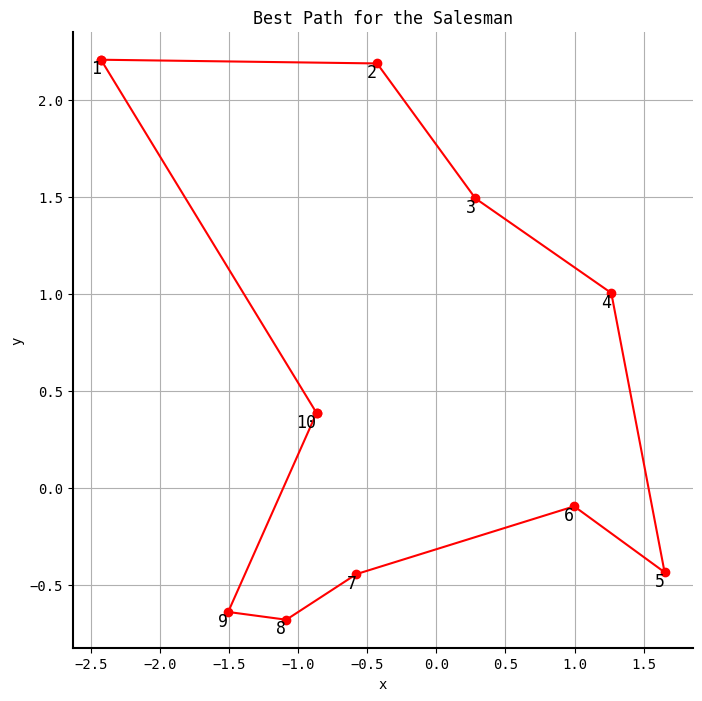

In [8]:
print_best_route(best_path)

## Dynamic Programming (Held-Karp algorithm)
To optimize the solution we can use [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming), specifically the [Held-Karp](https://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm) algorithm. While a brute-force solution to this problem involves evaluating all possible permutations of cities, resulting in an astronomic $O(n!)$ time complexity, the Held-Karp algorithm provides a more efficient aaproach, reducing the time complexity to $O(n^2 * 2^n)$ by breaking the problem into smaller subproblems. 

The algorithm works by storing and reusing the results of subproblems, allowing the solution to be built incrementally. The key challenge is that TSP requires visiting each city exactly once. This complexity grows rapidly as the number of cities increases, since every additional city adds exponentially more possible routes to consider. To combat this, Held-Karp uses a bitmasking strategy to represent the various subsets of cities that could be visited, and a recursive state-transition approach to build up the solution.

One of the critical insights of the Held-Karp algorithm is the use of bitmasking to efficiently represent subsets of cities. If we have $n$ cities, we can represent any subset of those cities as an $n$-bit binary number. Each bit in this binary number corresponds to a city, where a $1$ means the city is part of the subset, and a $0$ menas it is not. 

For example, consider four cities labeled as $0, 1, 2, 3$ the subset ${0, 2, 3}$ can be represented as the binary number $1101$. This representation is compact and allows for efficient subset operations. 

The dp table is designed around this bitmasking strategy. We define a state `dp[mask][i]` that represents the minimum distance to visit all cities in the subset represented by `maks` and end at city `i`. This table will have $2^n$ rows (one for each subset of cities) and $n$ columns (one for each possible ending city). For example the entry `dp[1101][2]` would store the minimum distance to visit the cities `{0, 2, 3}` and end at city `2`.

The key to the algorithm lies in the recurrence relation, which updates the `dp` table baed on previously computed subproblems. Suppose we have computed the shortest path to visit all cities in a subset mask, and we want to compute the shortest path for a larger subset that includes one more city.

To do this, we examine all possible ways to reach a city `i` in the subset `mask`. We transition from a smaller subset (one that excludes city `i`) by examining all possible cities `j` that could have preceded `i`. The dynamic programming recurrence is defined as follows:

$$dp[mask][i] = min(dp[mask / {i}[j] + dist(j,i)]$$

This formula essentially says that the minimum distance to visit the subset mask and end at city `i` is the minimum of the distances obtained by transitioning from any other city j in the subset. The distance from `j` to `i` is added to the minimum distance of reaching city `j` after visiting the subset `mask \setminus \{i\}`.

The Held-Karp algorithm starts by initializing the base case, where the only city in the subset is the starting city (typically city `0`). We set `dp[1][0] = 0`, which means that the minimum distance to visit the subset `{0}` and end at city `0` is zero because no travel is involved.

The algorithm then proceeds to build up solutions for larger and larger subsets. It begins with subsets of size two, then three, and so on, gradually filling in the dp table. For each subset, it calculates the minimum cost to reach each city by considering all possible previous cities.

Once all subsets have been processed, the final solution is found by examining the full set of cities, represented by the bitmask `111...1` (i.e., all cities are included). For each city `i`, we calculate the cost of returning to the starting city after visiting all cities:

$$finalccosts = min(dp[allcities][i] + dist(i,0))$$

This step checks all possible routes that end at any city i and adds the distance to return to the starting city, completing the cycle.

Once the minimum cost has been determined, it is often necessary to reconstruct the optimal path that leads to this solution. This can be done by backtracking through the `dp` table. Starting from the final state (where all cities have been visited), the algorithm traces back through the cities by looking at the transitions that minimized the distance at each step. By following these transitions, the algorithm reconstructs the optimal sequence of cities that forms the shortest tour.

In [9]:
def tsp_dp(coordinates):
    n = len(coordinates)
    distances = [[distance(p1, p2) for p2 in coordinates] for p1 in coordinates]
    
    dp = [[float('inf')] * n for _ in range(1 << n)]
    dp[1][0] = 0 
    
    for mask in range(1 << n):
        for u in range(n):
            if (mask & (1 << u)) == 0: 
                continue
            for v in range(n):
                if (mask & (1 << v)) == 0:
                    continue
                dp[mask][u] = min(dp[mask][u], dp[mask ^ (1 << u)][v] + distances[v][u])

    min_distance = float('inf')
    for u in range(1, n):
        min_distance = min(min_distance, dp[(1 << n) - 1][u] + distances[u][0])
    
    mask = (1 << n) - 1
    last = 0
    best_path = [0]
    for _ in range(n - 1):
        next_city = min(range(n), key=lambda v: dp[mask][v] + distances[v][last] if mask & (1 << v) else float('inf'))
        best_path.append(next_city)
        mask ^= (1 << next_city)
        last = next_city
    best_path.append(0)
    return best_path, min_distance

In [10]:
%%time
best_path, min_distance = tsp_dp(coordinates)

print("Best path:", best_path)
print("Minimum distance:", min_distance)

Best path: [0, 3, 9, 6, 7, 2, 8, 5, 1, 4, 0]
Minimum distance: 12.516978039789697
CPU times: user 39.1 ms, sys: 956 µs, total: 40.1 ms
Wall time: 39.7 ms


This time it will only take around 42ms! Let´s quickly plot the result again.

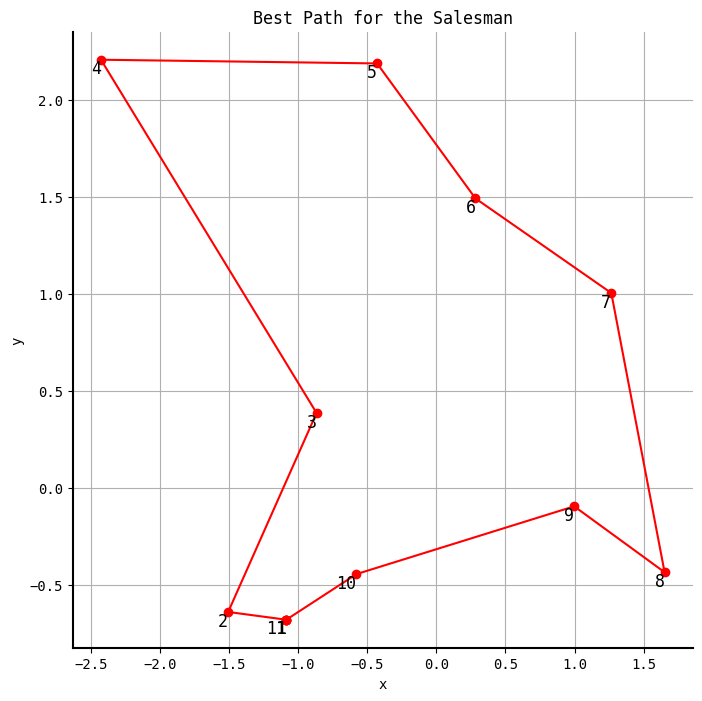

In [11]:
print_best_route(best_path)

The Held-Karp algorithm provides a significant improvement over brute-force solutions. By reducing the time complexity from factorial to $O(n^2 * 2^n)$, it makes the problem solvable for moderate numbers of cities (eg. up to 20-25 cities). Furthermore, the algorithm guarantees an exact solution to the problem, unlike heuristic methods that provide only approximate solutions.

## Brand and Bound
Brand and Bound (B&B) is a general algorithmic technique for solving combinational optimization problems, including the TSP. The primary idea behind B&B is to devide the problem into smaller subproblems (branching) and calculate bounds for each subproblem to determine wheather it can lead to an optimal solution. Subproblems that cannot possibly lead to a better solution than the best known are discarded (pruning), reducing the overall search space. 

For the TSP the Brand and Bound algorithm works as follows:

**1. Branching:**
- The problem is divided into subproblems by considering different possible paths or sequences of cities. Starting from an initial city, the algorithm explores all possible cities that can be visited next, formning branches of a decision tree. 

**2. Bounding:**
- For each subproblem (route), a lower bound on the possible tour leght is calculated. This bound estimates the minimum possible of any tour that includes the current partial route. 
- Common bounding methods include using the Minimum Spanning Tree (MST) or solving a relaxed version of the TSP to estimate the lower bound. 

We will need MST´s later on. So we need to know what a Minimum Spanning Tree is. Let´s first finish the process of B&B and then we will have a look at the MST. 

**3. Pruning:**
- if the lower bound of a subproblem is higher that the current best known solution (upper bound), that branch is pruned, as it cannot leat to an optimal solution. 
- The algorithm continues to explore only the branches that have the potential to produce a better solution. 

**4. Optimal Solution:**
- The algorithm continues branching, bounding, and pruning until all possibilities have been explored or pruned. The best valid route found during this process is the optimal solution to the TSP.

Imagine a small TSP with four cities: A, B, C, and D. The algorithm might start by choosing A as the starting city and then branching to B, C, and D. For each branch (e.g., A → B), the algorithm would calculate a bound for the remaining part of the route (e.g., B → ? → ? → A) and decide whether to explore further or prune that branch. This process continues until the shortest possible route is found.

**What is a Minimum Spanning Tree (MST)?**
A Minimum Spanning Tree (MST) is a concept from graph theory. Given a connected, undirected graph, a spanning tree is a subgraph that connects all the vertices together without any cycles and with the minimum possible total edge weight. 

In simpler terms, for a set of points, an MST is a way to connect all the possible points with the shortest possible total connection lenght, without any loops.  Here, we will use scipy to calculate the MST. 

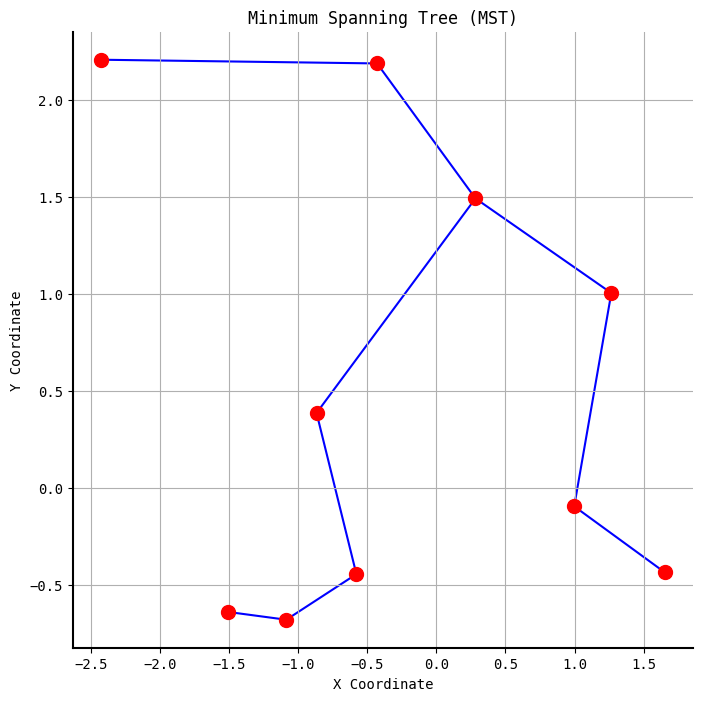

In [12]:
coordinates = np.array(coordinates)
dist_matrix = distance_matrix(coordinates, coordinates)
mst = minimum_spanning_tree(dist_matrix).toarray()

plt.figure(figsize=(8, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red', s=100, zorder=5)

for i in range(len(coordinates)):
    for j in range(len(coordinates)):
        if mst[i, j] != 0: 
            plt.plot([coordinates[i, 0], coordinates[j, 0]], 
                     [coordinates[i, 1], coordinates[j, 1]], 
                     'b-', zorder=1)

plt.title("Minimum Spanning Tree (MST)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

We can also use [Kruskal´s algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) to find the MST. Without a deep dive into the Kruskal´s algorithm it works as follows:

**1. Representation of the Graph:**
- The algorithm begins by representing the graph as a list of all possible connections between pairs of vertices. Each connection has a weight that represents the distance or cost associated with that edge.

**2. Sorting the Edges:**
- The algorithm then sorts all the connections in the graph in order of increasing weight. This sorting step ensures that the smallest possible edge is considered first, allowing the algorithm to build the MST using the least expensive edges.

**3. Initialization:**
- Initially, each vertex in the graph is treated as a separate component or set. The goal of the algorithm is to gradually merge these components by adding edges, ensuring that all vertices become connected in a single component by the end of the process.

**4. Edge Selection and Component Mapping:**
- The algorithm iterates through the sorted list of edges, considering each edge in turn:
    - For each edge, it checks whether the two vertices connected by that edge belong to different components. If they are in different components, adding this edge will not form a cycle.
    - When an edge connects two different components, the edge is added to the MST, and the two components are merged into one. This merging process involves updating the sets of vertices to reflect that they are now part of the same connected component.
    
**5. Cycle Prevention:**
- If the two vertices connected by an edge are already in the same component, adding that edge would create a cycle. In this case, the edge is skipped, and the algorithm moves on to the next edge in the sorted list.

**6. Completion of the MST:**
- The process continues, adding edges to the MST and merging components, until the MST contains exactly one less edge than the number of vertices in the graph. At this point, all vertices are connected in a single component, and the MST is complete.

In [13]:
# Helper function to find the root of a vertex
def find(parent, i):
    if parent[i] == i:
        return i
    return find(parent, parent[i])

In [14]:
# Helper function to union two subsets
def union(parent, rank, x, y):
    root_x = find(parent, x)
    root_y = find(parent, y)
    
    if rank[root_x] < rank[root_y]:
        parent[root_x] = root_y
    elif rank[root_x] > rank[root_y]:
        parent[root_y] = root_x
    else:
        parent[root_y] = root_x
        rank[root_x] += 1

In [15]:
def kruskal_mst(coordinates):
    n = len(coordinates)
    edges = []

    # Step 1: Create a list of all edges with their distances
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            edges.append((distance, i, j))

    # Step 2: Sort all edges by weight (distance)
    edges = sorted(edges, key=lambda x: x[0])

    parent = list(range(n))
    rank = [0] * n

    mst_edges = []

    # Step 3: Process each edge, checking if it forms a cycle
    for distance, u, v in edges:
        root_u = find(parent, u)
        root_v = find(parent, v)

        # If including this edge does not form a cycle
        if root_u != root_v:
            mst_edges.append((u, v))
            union(parent, rank, root_u, root_v)

        # Stop if we have found enough edges for the MST
        if len(mst_edges) == n - 1:
            break

    return mst_edges

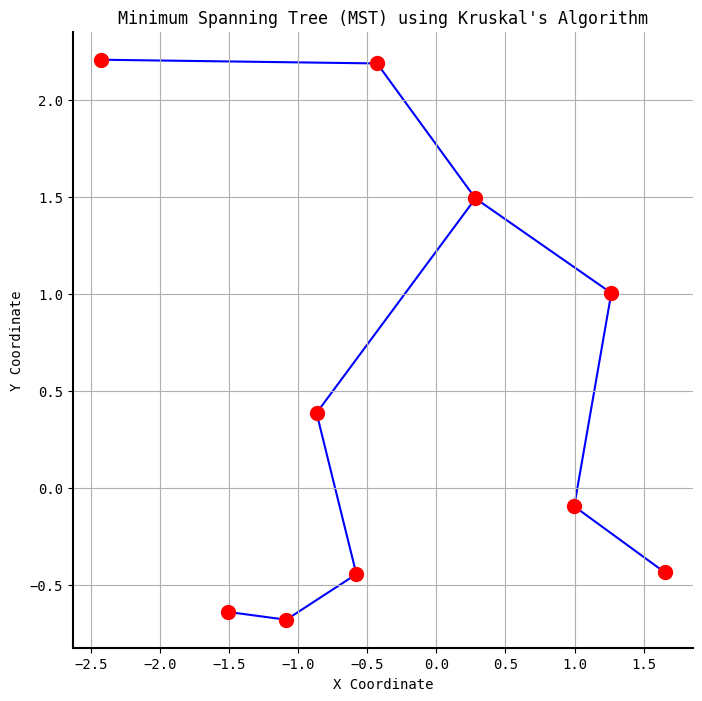

In [16]:
mst_edges = kruskal_mst(coordinates)
plt.figure(figsize=(8, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red', s=100, zorder=5)

for u, v in mst_edges:
    plt.plot([coordinates[u, 0], coordinates[v, 0]], 
             [coordinates[u, 1], coordinates[v, 1]], 
             'b-', zorder=1)

plt.title("Minimum Spanning Tree (MST) using Kruskal's Algorithm")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

Now let´s hop into the implementation of the Branch and Bound algorithm. 

In [17]:
def tsp_branch_and_bound(coordinates):
    n = len(coordinates)
    
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance_matrix[i][j] = distance(coordinates[i], coordinates[j])
            distance_matrix[j][i] = distance_matrix[i][j]

    min_distance = float('inf')
    best_path = []
    initial_path = [0]
    initial_bound = 0
    
    def branch_and_bound(path, bound, level):
        nonlocal min_distance, best_path
        
        if level == n - 1:
            current_distance = bound + distance_matrix[path[-1]][path[0]]
            if current_distance < min_distance:
                min_distance = current_distance
                best_path = path + [path[0]]
            return
        
        for i in range(1, n):
            if i not in path:
                new_bound = bound + distance_matrix[path[-1]][i]
                if new_bound < min_distance:
                    branch_and_bound(path + [i], new_bound, level + 1)

    branch_and_bound(initial_path, initial_bound, 0)

    return best_path, min_distance

In the `tsp_branch_and_bound` function we first create a matrix `distance_matrix` in a 2D array that stores the distances between each pair of cities. The loop iterates over each pair of cities (i,j) and calculates the Euclidean distance between them using the `distance` function. `min_distance` keeps track of the shortest path and is initialized to infinity. 

The `branch_and_bound` function is a recursive function that explores different routes. The parameter `path` represents the current path being explored, `bound` is the total distance in the current path and `level` is the depth of the recursion, indicating how many cities have benn visited. 

The base case is if `level == n - 1`, it means all cities have been visited and the algorithm is ready to complete the cycle by returning to the starting city.  The `current_distance` is calculated as the total distance of the curren troute plus the distance from the last city back to the starting city. If `curent_distance` is less than `min_distance`, it updates `min_distance` and `best_path` with the current route. 

Finally the recursive exploration will iterate over all cities (from 1 to n-1) to explore all possible paths. It checks if the city `i` is not already in the current `path`. If not, it calculates `new_bound` which is the cost of traveling from last city in `path` to city `i` added to the current bound. 
If `new_bound` is less than `min_distance` the algorithm continues exploring by recursively calling `branch_and_bound` with the updated path, new bound, and increased level. This step is crucial for pruning. If `new_bound` exceeds the current `min_distance`, that path is not explored further, saving computational resources. 

In [18]:
%%time
coordinates = tiny[['A', 'B']].values.tolist()
best_path, min_distance = tsp_branch_and_bound(coordinates)
print("Best path:", best_path)
print("Minimum distance:", min_distance)

Best path: [0, 3, 9, 6, 7, 2, 8, 5, 1, 4, 0]
Minimum distance: 12.516978039789697
CPU times: user 271 ms, sys: 0 ns, total: 271 ms
Wall time: 270 ms


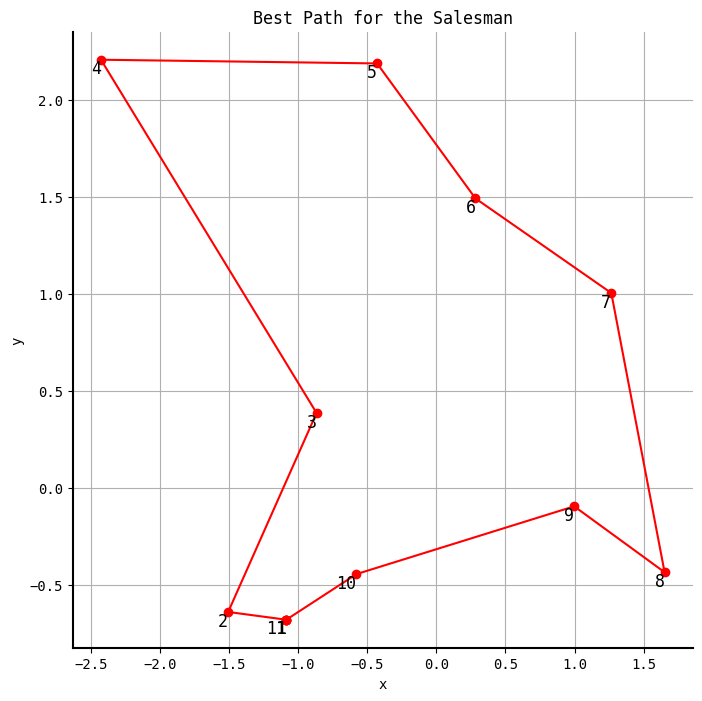

In [19]:
print_best_route(best_path)

# Small Cities
## Nearest Neighbor 
We can´t use Held-Karp or Brand and Bound to solve a TSP with 30 cities. For 30 cities, the number of possible permutations is $29!$, which is an astronomically large number (approximately $8841 * 10^{30}$). Instead we can use the nearest Neightbor (NN) algorithm. It is a heuristic method used to find an approximate solution to the TSP. The nearest Neighbor algorithm provides a practical approach to finding solutions to this problem, albeit not always the optimal one. Its simplicity and speed make it a popular choice in scenarios where a quick and reasonably good soltuion is preferred over an exhaustive search for the absolute best route. 

The essence of the [Nearest Neighbor algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm) lies in its greedy nature. The algorithm begins its journey from an arbitrary starting point, often the first city in the list. From this initial city, it then seeks out the nearest city that has not yet been visited. This closest city becomes the next stop on the tour. After moving to this city, it is marked as visited, and the algorithm repeats the process: it again looks for the nearest unvisited city from the current position.

This process continues until all cities have been visited. Once the last unvisited city has been added to the tour, the algorithm completes the journey by returning to the starting city, thereby closing the loop. The resulting path represents the Nearest Neighbor solution to the TSP.

The primary advantage of the Nearest Neighbor algorithm is its simplicity and speed. Unlike exact methods that aim to find the optimal solution by exploring all possible routes, Nearest Neighbor quickly finds a feasible route, making it particularly useful when dealing with large numbers of cities. The computational efficiency of the algorithm is one of its strongest selling points, as it operates in a time complexity of $O(n^1)$ where $n$ is the number of cities. This is significantly faster than algorithms that try to calculate every possible path, which have factorial time complexities.

However, this speed and simplicity come with a trade-off. The Nearest Neighbor algorithm is not guaranteed to find the shortest possible route. Because it always chooses the nearest available city without considering the broader consequences of this choice, it can sometimes make decisions that lead to suboptimal results. For example, by choosing a nearby city early in the process, the algorithm might set itself up to make much longer jumps later on, potentially increasing the total distance traveled. This tendency is known as the "greedy" nature of the algorithm—each choice is made based on immediate benefit without consideration for the overall path.

Despite its potential for suboptimal solutions, the Nearest Neighbor algorithm is often surprisingly effective, especially for small to moderately sized problems. It provides a good baseline solution, which can sometimes be close to the optimal path. Moreover, it serves as a useful starting point for more sophisticated algorithms that refine the initial solution provided by Nearest Neighbor.


In [20]:
def nearest_neighbor(coordinates):
    n = len(coordinates)
    unvisited = list(range(n))
    path = []
    
    current_city = unvisited.pop(0)
    path.append(current_city)
    
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: distance(coordinates[current_city], coordinates[city]))
        path.append(nearest_city)
        unvisited.remove(nearest_city)
        current_city = nearest_city
    
    path.append(path[0])
    total_distance = sum(distance(coordinates[path[i]], coordinates[path[i + 1]]) for i in range(n))
    return path, total_distance

In [21]:
%%time
coordinates = small[['A', 'B']].values.tolist()
best_path, min_distance = nearest_neighbor(coordinates)
print("Best path:", best_path)
print("Minimum distance:", min_distance)

Best path: [0, 19, 6, 9, 29, 22, 20, 28, 4, 13, 3, 7, 25, 15, 12, 24, 8, 17, 16, 21, 27, 10, 11, 14, 2, 23, 5, 18, 26, 1, 0]
Minimum distance: 66.79316375709949
CPU times: user 1.68 ms, sys: 49 µs, total: 1.73 ms
Wall time: 1.71 ms


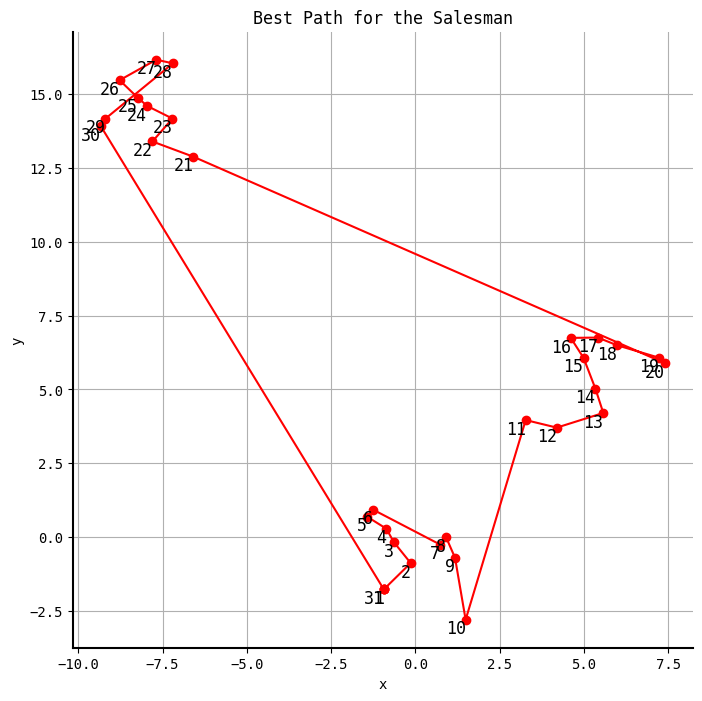

In [22]:
print_best_route(best_path)

Between city 28 and 29 is a bigger gap. So the question is whether this is really the shortest way to visit all the cities? Let us note that the Nearest Neighbor approach has calculated a minimum distance of approx. 66. 

## Genetic Algorithm
Genetic Algorithms (GAs) are a class of optimization algorithms inspired by the process of natural selection, where the strongest individual in a population survive and reproduce. These algorithm may also not deliver the best possible solution, but they can also quickly identify good approximates. It is difficult to estima the amount of time it takes to complete a genetic algorithm since it heavily depends on population size, number of generations and other factors. 

In the context of the TSP, a genetic algorithm evolves a population of possible routes (solutions) over several generations. The algorithm iteratively selects the best routes, combines them to produce new routes, introduces random mutations, and selects the best solutions from the new population. 

A state diagram can be used to visualize the process with the genetic algorith. 

![](https://www.neuraldesigner.com/images/genetic_algorithm.webp)

*Source: [Genetic algorithms for feature selection in machine learning by Fernando Gomez](https://www.neuraldesigner.com/blog/genetic_algorithms_for_feature_selection/)*

**1. Representation (Chromosome):**
In a GA, each potential solution is encoded as a chromosome. For the TSP, a chromosome is simply a permutation of city indices, representing a possible route. For example, for five cities, a chromosome might be `[4, 2, 0, 3, 1]`, where each number represents a city. Another chromosome could be `[0, 4, 3, 2, 1]`. 

**2. Population Initialization:**
The algorithm starts with a population of randomly generated chromosomes. Each chromosome represents a different possible route. The population size (number of chromosomes) is an important parameter that affects the diversity of solutions and the efficiency of thee algorithm. 

In [23]:
def create_route(n):
    route = list(range(n))
    random.shuffle(route)
    return route

In [24]:
def initial_population(pop_size, n):
    return [create_route(n) for _ in range(pop_size)]

In [25]:
chromosome = initial_population(1, len(coordinates))
print(chromosome)

[[13, 11, 8, 18, 19, 28, 6, 2, 22, 1, 0, 12, 7, 9, 24, 10, 4, 15, 25, 16, 26, 3, 5, 29, 21, 20, 14, 17, 27, 23]]


This could be a possible solution. I created a new random chromosome which represents a random route. 

**3. Fitness Function:**
The fitness function evaluates how good each route is. For TSP, the fitness is usually defined as the inverse of the route´s total distance. Shorter routes have higher fitness values. 

In [26]:
def route_distance(route, coordinates):
    return sum(distance(coordinates[route[i]], coordinates[route[i + 1]]) for i in range(len(route) - 1)) + distance(coordinates[route[-1]], coordinates[route[0]])

In [27]:
def fitness(route, coordinates):
    return 1 / route_distance(route, coordinates)

The `route_distance(route, coordinates)` function calculates the total distance of a route. The `fitness` function simply returns the inverse of this distance. 

In [28]:
chromosome_fitness = fitness(chromosome[0], coordinates)
print("Fitness of the chromosome:", chromosome_fitness)

Fitness of the chromosome: 0.002756101825003419


The fitness for this specifiy route is very low. Let´s plot the route. 

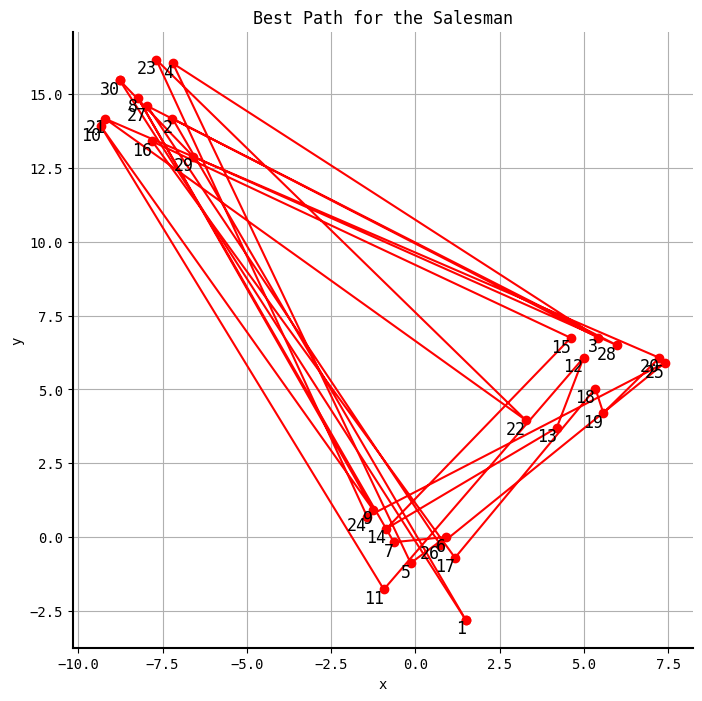

In [29]:
print_best_route(chromosome[0])

**4. Selection:**
Selection is the process by which the algorithm chooses which chromosomes will be used as parents to produce the next generation. Typically, better-performing (higher fitness) chromosomes are more likely to be selected. This mimics the "survival of the fittest" concept. 

```python
population = sorted(population, key=lambda x: fitness(x, coordinates), reverse=True)
parents = population[:elite_size]
```

In the code above, the selection is implicit in the sorting step where the population is sorted by fitness, and the top `elite_size` chromosomes are selected as parents. 

**5. Crossover (Recombination):**
Crossover is the process of combining two parent chromosomes to produce a new offspring chromosome. This mimics the biological reproduction. The goal is to produce a new route that inherits good properties from both parents. I will use the Ordered Crossover technique where a segment of the first parent´s route is directly copied to the child and the remaining positions are filled with cities from the second parent, preserving their order. 

Let´s have an example to make this technique a bit more clear. We have two parents:
- Parent 1: `[1, 2, 3, 4, 5, 6, 7, 8, 9, 0]`
- Parent 2: `[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]`

Next we have to create two random chrossoverpoints `start` and `end`. These points define a segment that will be copied directly from the first parent to the child. Let´s select crossover points 3 and 6. This means that the segment `[4, 5, 6]` will be copied directly from Parent 1. 

The initial child is now: `[None, None, None, 4, 5, 6, None, None, None, None]`

Finally we have to fill the remaining values from Parent 2. The final child chromosome after applying ordered crossover is: `[9, 8, 7, 4, 5, 6, 3, 2, 1, 0]`. 

In [30]:
def crossover(parent1, parent2):
    start, end = sorted([random.randint(0, len(parent1) - 1) for _ in range(2)])
    child = [None] * len(parent1)
    child[start:end] = parent1[start:end]
    p2 = [item for item in parent2 if item not in child]
    child = [p2.pop(0) if item is None else item for item in child]
    return child

**6. Mutation:**
Mutation introduces random changes to an offspring chromosome, helping to maintain diversity in the population and preventing the algorithm from getting stuck in local optima. The mutation is typically a small, random change, such as swapping two cities in the route. The code below randomly swaps two cities in the route with a probability defined by the `mutation_rate`. 

In [31]:
def mutate(route, mutation_rate):
    for i in range(len(route)):
        if random.random() < mutation_rate:
            j = random.randint(0, len(route) - 1)
            route[i], route[j] = route[j], route[i]
    return route

**7. Replacement:**
After generating offspring via crossover and mutation, the GA forms a new population by selecting the best routes from both the parents and offsprings. This step ensures that the best solution is carried over to the next generation. 

```python
population = parents + children
```

In this case, the new population consists of the top `elite_size` parents and the newly created children. 

**8. Termination:**
The algorithm repeats the selection, crossover, mutation, and replacement processes for a set number of generations or until the solution no longer improves significantly. At the end of the process, the best route found during all generations is returned as the final solution.

In [32]:
def plot_route(route, coordinates, generation, line):
    x = [coordinates[city][0] for city in route] + [coordinates[route[0]][0]]
    y = [coordinates[city][1] for city in route] + [coordinates[route[0]][1]]
    line.set_data(x, y)
    plt.title(f"Generation {generation + 1}")

In [33]:
def genetic_algorithm(coordinates, pop_size=100, elite_size=20, mutation_rate=0.01, generations=300):
    n = len(coordinates)
    population = initial_population(pop_size, n)
    history = []
    for gen in range(generations):
        # Rank routes based on fitness
        population = sorted(population, key=lambda x: fitness(x, coordinates), reverse=True)
        # Select the best routes to be parents
        parents = population[:elite_size]
        # Generate children
        children = []
        for _ in range(pop_size - elite_size):
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            children.append(mutate(child, mutation_rate))
        # Form the new population
        population = parents + children
        # Best route and distance of the current generation
        best_route = population[0]
        best_distance = route_distance(best_route, coordinates)
        history.append((best_route, gen, best_distance))
    best_route = population[0]
    best_distance = route_distance(best_route, coordinates)
    return history, best_route, best_distance

In [34]:
def plot_route_animation(history, coordinates):
    frames = []
    for gen, (route, _, _) in enumerate(history):
        x = [coordinates[city][0] for city in route] + [coordinates[route[0]][0]]
        y = [coordinates[city][1] for city in route] + [coordinates[route[0]][1]]
        frames.append(go.Frame(
            data=[go.Scatter(x=x, y=y, mode='lines+markers', marker=dict(size=8), line=dict(color='blue'))],
            name=f'Generation {gen + 1}',
            layout=go.Layout(title_text=f"Generation {gen + 1} - Traveling Salesman Problem")
        ))
    
    fig = go.Figure(
        data=[frames[0].data[0]],
        layout=go.Layout(
            title="Traveling Salesman Problem - Best Route Per Generation",
            xaxis=dict(title="X Coordinate"),
            yaxis=dict(title="Y Coordinate"),
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None, dict(frame=dict(duration=50, redraw=True),
                                                             fromcurrent=True,
                                                             mode='immediate')]),
                                       dict(label="Pause",
                                            method="animate",
                                            args=[[None], dict(frame=dict(duration=0, redraw=False),
                                                               mode='immediate')])])]
        ),
        frames=frames
    )
    fig.show()

In [35]:
%%time
coordinates = small[['A', 'B']].values.tolist()
history, best_route, best_distance = genetic_algorithm(coordinates)
print("Best route:", best_route)
print("Best distance:", best_distance)

Best route: [25, 6, 9, 29, 22, 10, 1, 26, 23, 5, 18, 2, 14, 11, 27, 24, 12, 3, 28, 20, 19, 0, 13, 4, 7, 15, 8, 17, 16, 21]
Best distance: 74.19270997273225
CPU times: user 2.09 s, sys: 1.84 ms, total: 2.1 s
Wall time: 2.1 s


The results vary slightly for each run since we have a lot of randomness in the process. However, if we remember the result of Nearest Neighbor above we see a small change in the top right. In addition, the shortest distance of 66 should have been reduced a little further. If this is not the case, the parameters such as population, elite_size, mutation_rate or generations can be adjusted when using genetic algorithm. 

In [36]:
plot_route_animation(history, coordinates)

# Medium Cities
## Christofides Algorithm

[Christofides Algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm) is a heuristic algorithm that guarantees that the solution it provides is within 1.5 times the optimal tour length. It is particularly useful when dealing with metric TSP, where the triangle inequality holds, meaning the direct distance between two nodes is never greater than the sum of distances when traveling via another node. 
Here is a step-by-step breakdown of the Christofides Algorithm. 

**1. Generate a Minimum Spanning Tree (MST)**:
We already know that a MST is a tree that connects all vertices (cities) in the graph with the minimum possible sum of edge weights. This ensures that all cities are connecged with the smallest possible distance. 
- **Goal:** To ensure that all cities are connected with the least amount of "extra" distance.
- **Algorithm:** The MST can be computed using Prim’s algorithm or Kruskal’s algorithm. Both algorithms efficiently find a tree that spans all cities and minimizes the sum of the edge weights (distances).

In Christofides’ algorithm, the MST will form the foundation of our tour. However, the MST does not necessarily yield a valid TSP solution because it might not return to the starting point, nor does it visit every city exactly once.


In [37]:
coordinates = medium[['A', 'B']].values.tolist()
mst_edges = kruskal_mst(coordinates)

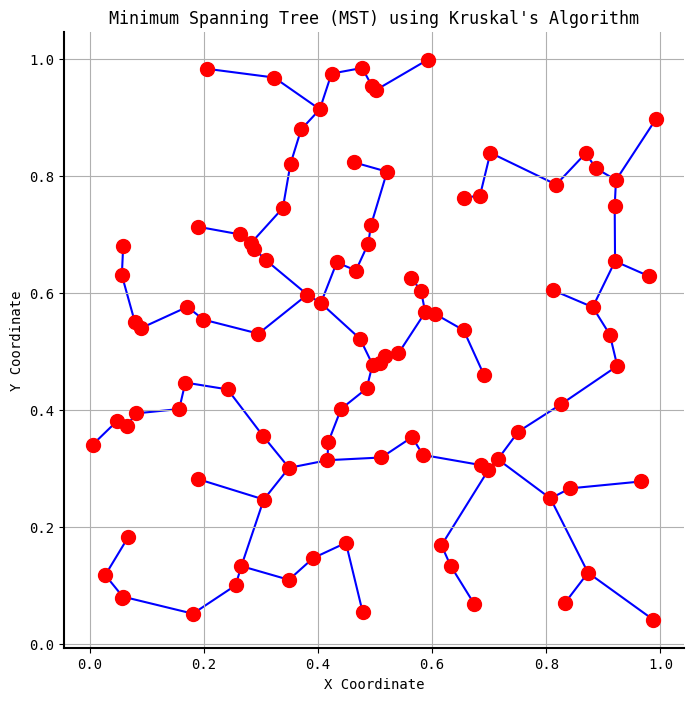

In [38]:
coordinates = np.array(coordinates)
plt.figure(figsize=(8, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red', s=100, zorder=5)

for u, v in mst_edges:
    plt.plot([coordinates[u, 0], coordinates[v, 0]], 
             [coordinates[u, 1], coordinates[v, 1]], 
             'b-', zorder=1)

plt.title("Minimum Spanning Tree (MST) using Kruskal's Algorithm")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

**2. Find Odd-Degree Vertices in the MST**:
A vertex in a graph has an odd degree if the number of edges connected to it is odd. After constructing the MST, we identify all vertices in the tree that have odd degrees.

- **Why odd-degree vertices?:** Euler’s theorem states that a graph can contain an Eulerian circuit (a path that visits every edge exactly once and returns to the start) only if all vertices have an even degree. Therefore, we need to "fix" the odd-degree vertices to ensure we can create an Eulerian circuit later.
- **Next steps:** We will add additional edges between odd-degree vertices to create a structure that allows us to form an Eulerian circuit.

In [39]:
def find_odd_degree_vertices(mst_edges, num_nodes):
    degree_count = [0] * num_nodes
    for u, v in mst_edges:
        degree_count[u] += 1
        degree_count[v] += 1
    
    odd_degree_nodes = [i for i in range(num_nodes) if degree_count[i] % 2 != 0]
    return odd_degree_nodes

In [40]:
num_nodes = len(coordinates)
odd_degree_nodes = find_odd_degree_vertices(mst_edges, num_nodes)

**3. Minimum Weight Perfect Matching on Odd-Degree Vertices:**
Next, we perform a minimum weight perfect matching on the odd-degree vertices identified in Step 2. A perfect matching is a set of edges such that each vertex is connected to exactly one other vertex, and no vertices are left unmatched.

- **Goal:** To pair up all the odd-degree vertices in such a way that the sum of the weights (distances) of the matched edges is minimized.
- **Algorithm:** A greedy matching algorithm or more sophisticated techniques such as the Blossom algorithm can be used to find the minimum weight perfect matching.
- **Effect:** Once the matching is added to the MST, all vertices will have an even degree.

In [41]:
def greedy_matching(odd_degree_nodes, coordinates):
    matching_edges = []
    while odd_degree_nodes:
        u = odd_degree_nodes.pop()
        min_edge = (None, float('inf'))
        for v in odd_degree_nodes:
            dist = np.linalg.norm(np.array(coordinates[u]) - np.array(coordinates[v]))
            if dist < min_edge[1]:
                min_edge = (v, dist)
        matching_edges.append((u, min_edge[0]))
        odd_degree_nodes.remove(min_edge[0])
    
    return matching_edges

In [42]:
matching_edges = greedy_matching(odd_degree_nodes, coordinates)

**4. Create a Multigraph with Even Degree Vertices (Eulerian Graph):**
Once the perfect matching is added to the MST, we have a multigraph (a graph where some edges might be duplicated) in which every vertex has an even degree.

- **Why is this important?:** A graph with all even-degree vertices is called an [Eulerian graph](https://en.wikipedia.org/wiki/Eulerian_path), meaning it contains an Eulerian circuit. An Eulerian circuit is a path that visits every edge exactly once and returns to the starting point.



In [43]:
def create_multigraph(mst_edges, matching_edges):
    multigraph = defaultdict(list)
    for u, v in mst_edges + matching_edges:
        multigraph[u].append(v)
        multigraph[v].append(u)
    return multigraph

In [44]:
multigraph = create_multigraph(mst_edges, matching_edges)

**5. Generate an Eulerian Circuit and Convert It into a Hamiltonian Cycle:**
Using the multigraph from Step 4, we can now find an Eulerian circuit. This can be done using [Hierholzer’s algorithm](https://en.wikipedia.org/wiki/Eulerian_path#Hierholzer's_algorithm), which finds an Eulerian circuit in linear time by traversing the graph, ensuring that every edge is used exactly once.

However, an Eulerian circuit is not yet the solution to the TSP because it might visit some vertices multiple times. The goal of TSP is to visit each vertex exactly once, so we need to convert this Eulerian circuit into a [Hamiltonian cycle](https://en.wikipedia.org/wiki/Hamiltonian_path#:~:text=10%20External%20links-,Definitions,path%20between%20the%20two%20vertices.).

- **Conversion to Hamiltonian Cycle:** This is done by following the Eulerian circuit and skipping over vertices that have already been visited. When we encounter a previously visited vertex, we simply bypass it and move to the next unvisited vertex.
- **Final Result:** The resulting path will be a Hamiltonian cycle, which is a tour that visits each city exactly once and returns to the starting city.


In [45]:
def find_eulerian_circuit(multigraph, start):
    stack = [start]
    circuit = []
    current_path = defaultdict(list)
    for u, neighbors in multigraph.items():
        current_path[u] = neighbors.copy()
    
    while stack:
        u = stack[-1]
        if current_path[u]:
            v = current_path[u].pop()
            current_path[v].remove(u)
            stack.append(v)
        else:
            circuit.append(stack.pop())
    
    return circuit

In [46]:
def convert_to_hamiltonian_path(eulerian_circuit):
    visited = set()
    hamiltonian_path = []
    for node in eulerian_circuit:
        if node not in visited:
            hamiltonian_path.append(node)
            visited.add(node)
    
    return hamiltonian_path + [hamiltonian_path[0]] 

In [47]:
def visualize_eulerian_circuit(coordinates, eulerian_circuit):
    x_coords = [coord[0] for coord in coordinates]
    y_coords = [coord[1] for coord in coordinates]

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, color='red', s=100, zorder=2)
    
    for i in range(len(eulerian_circuit) - 1):
        u = eulerian_circuit[i]
        v = eulerian_circuit[i + 1]
        x_values = [coordinates[u][0], coordinates[v][0]]
        y_values = [coordinates[u][1], coordinates[v][1]]
        plt.plot(x_values, y_values, 'r-', lw=2, zorder=1)
        plt.arrow(coordinates[u][0], coordinates[u][1],
                  coordinates[v][0] - coordinates[u][0],
                  coordinates[v][1] - coordinates[u][1],
                  head_width=0.02, length_includes_head=True, fc='green', ec='green')

    u = eulerian_circuit[-1]
    v = eulerian_circuit[0]
    plt.plot([coordinates[u][0], coordinates[v][0]],
             [coordinates[u][1], coordinates[v][1]], 'r-', lw=2, zorder=1)

    plt.title("Eulerian Circuit Visualization")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

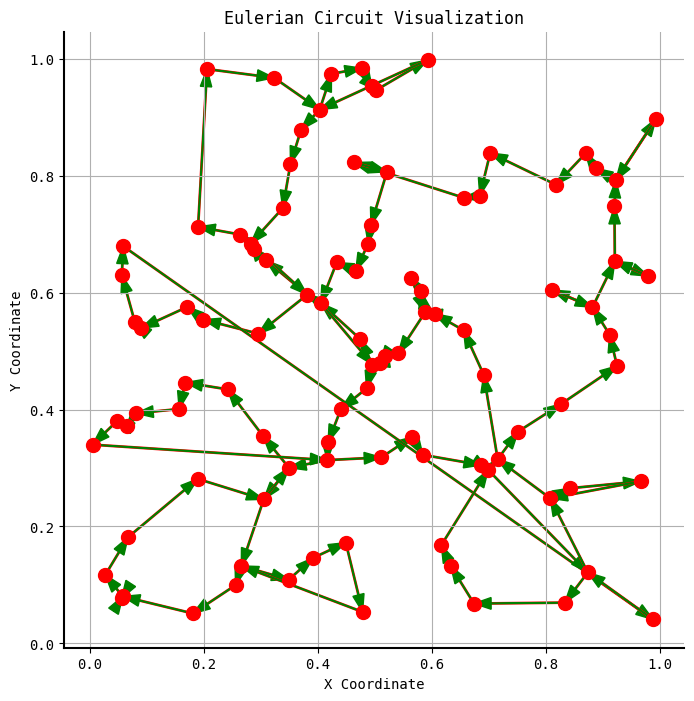

In [48]:
eulerian_circuit = find_eulerian_circuit(multigraph, 0)
visualize_eulerian_circuit(coordinates, eulerian_circuit)

In [49]:
%%time
tsp_path = convert_to_hamiltonian_path(eulerian_circuit)

total_distance = 0
for i in range(len(tsp_path) - 1):
    total_distance += np.linalg.norm(np.array(coordinates[tsp_path[i]]) - np.array(coordinates[tsp_path[i + 1]]))
print("Best route:", tsp_path)
print("Best distance:", total_distance)

Best route: [0, 35, 21, 99, 50, 8, 85, 10, 2, 36, 47, 89, 31, 28, 32, 98, 94, 30, 19, 56, 66, 23, 48, 24, 92, 76, 52, 40, 65, 14, 91, 22, 62, 26, 51, 39, 93, 96, 6, 72, 41, 25, 67, 29, 86, 59, 74, 75, 3, 95, 44, 83, 68, 42, 37, 5, 78, 11, 79, 43, 60, 97, 46, 77, 53, 69, 45, 82, 71, 16, 57, 12, 27, 54, 88, 63, 55, 1, 20, 18, 81, 84, 17, 61, 38, 73, 87, 80, 7, 49, 90, 4, 13, 9, 15, 34, 70, 33, 64, 58, 0]
Best distance: 9.561984362386912
CPU times: user 3.57 ms, sys: 46 µs, total: 3.62 ms
Wall time: 3.05 ms


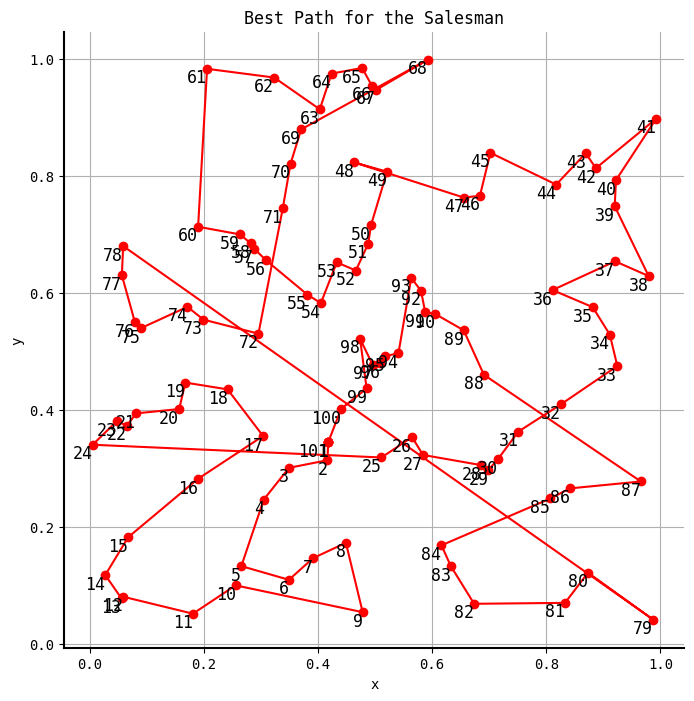

In [50]:
print_best_route(tsp_path)

Christofides' Algorithm provides an approximation ratio of 1.5 for metric TSP. This means that the length of the tour produced by Christofides' algorithm is at most 1.5 times the length of the optimal TSP tour. The reasoning behind this guarantee is as follows:

1. The cost of the MST is a lower bound on the cost of the optimal TSP tour. This is because removing any single edge from the optimal TSP tour leaves a spanning tree.

2. The cost of the perfect matching is at most half of the cost of the optimal TSP tour. This is because the matching connects only odd-degree vertices and is performed on a subset of vertices, minimizing the sum of edge weights.

By combining these two properties, Christofides' algorithm ensures that the total tour cost is no more than 1.5 times the optimal tour cost.

# Large Cities
## Ant Colony Optimization (ACO)

[Ant Colony Optimization](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms) (ACO) is a probabilistic optimization technique inspired by the behavior of real ants searching for food. Real ants leave pheromone trails as they move, and these trails help guide other ants towards the food source. Over time, shorter paths become more reinforced with pheromones, leading more ants to follow those paths. ACO uses this concept to solve complex optimization problems, like the Traveling Salesman Problem (TSP).

Ant colony optimization is easy to implement and does not require complex mathematical knowledge. It is a flexible algorithm and can be used for various problem domains. It can handle multiple objects and constraints. Also it can find high-quality solutions in a large solution space. It has the ability to find near-optimal soltuions, even in cases where the search space is very large or poorly understand. 

But there are also a few disadvantages. The algorithm may converge to a suboptimal solution if the parameter settings are not carefully selected. It may become computationally expensive if there are a large number of ants and/or iterations required to find a solution. The quality of the solution also may be depent on the pheromone initialization, which can be difficult to optimize. 

![](https://archive.conscientiabeam.com/index.php/79/article/download/2684/4829/7032)

*[Source](https://archive.conscientiabeam.com/index.php/79/article/view/2684/4829)* - Behaviour of ants searching for food

The core idea of ACO can be broken down into the following key-components: 

**1. Ants and Solutions:**
- Ants in the ACO algorithm represent agents that build solutions to the optimization problem.
- Each ant constructs a solution incrementally by moving from one state (or city) to another. The probability of selecting the next state depends on pheromones and heuristic information (like distance).

**2. Pheromenes:**
- Pheromones in the ACO algorithm represent a form of memory shared among ants. They are updated after each iteration based on the quality of the solutions found by the ants.
- The more pheromones on a path, the more attractive it becomes for subsequent ants, simulating how real ants mark paths that lead to food sources.

**3. xploration vs. Exploitation:**
Ants balance exploration (finding new solutions) and exploitation (refining current solutions). The pheromone concentration helps ants exploit good solutions by biasing their choice of paths, while a stochastic component ensures ants also explore less-used paths.

**4. Pheromone Evaporation:**
To avoid getting stuck in local optima, pheromones evaporate over time. This means that unless a path is continually reinforced by multiple ants finding it useful, its pheromone level decreases, allowing other paths to be explored.

**5. Heuristic Information:**
Heuristic information, typically the inverse of the distance between cities (in TSP), is used to guide ants toward promising areas of the solution space. This is combined with pheromone levels to determine the next step in the path construction process.

**6. Global Best vs. Local Best Solutions:**
In some versions of ACO, only the best-performing ant in a given iteration deposits pheromones, while in others, all ants contribute. This strategy helps accelerate the convergence toward the best solution by reinforcing the most successful paths.

We can also break down the steps how ACO can be used to solve the TSP:

1. **Initialization**
    - The distances between all cities are calculated.
    - An initial pheromone matrix is created, usually with equal values for all paths.
2. **Construct Solutions**
    - Each ant starts from a random city.
    - The ant chooses the next city based on a probabilistic decision that depends on the pheromone level and the inverse of the distance between the current city and unvisited cities.
    - Once all cities are visited, the ant returns to the starting city to complete the tour.
3. **Update Pheromones**
    - Pheromone levels are updated globally after all ants have completed their tours.
    - Evaporation reduces the pheromone levels on all paths.
    - Paths that were used by the ants (and especially shorter paths) receive additional pheromone.
4. **Repeat**
    - The process repeats for a given number of iterations or until a stopping criterion (like no improvement over several iterations) is met.
5. **Best Solution**
    - The algorithm keeps track of the best solution found over all iterations and returns it as the final result.

In [51]:
class AntColony:
    def __init__(self, coordinates, num_ants, num_iterations, alpha=1, beta=2, evaporation_rate=0.5, pheromone_deposit=100):
        self.coordinates = coordinates
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.pheromone_deposit = pheromone_deposit
        self.num_cities = len(coordinates)
        self.distances = self.compute_distances(coordinates)
        self.pheromones = np.ones((self.num_cities, self.num_cities))
    
    def compute_distances(self, coordinates):
        """Computes the distance matrix."""
        distances = np.zeros((self.num_cities, self.num_cities))
        for i in range(self.num_cities):
            for j in range(i + 1, self.num_cities):
                dist = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
                distances[i][j] = dist
                distances[j][i] = dist
        return distances
    
    def run(self):
        """Main loop to run the ACO algorithm."""
        best_distance = float('inf')
        best_path = None

        for iteration in range(self.num_iterations):
            all_paths = []
            all_distances = []
            
            for ant in range(self.num_ants):
                path = self.construct_solution()
                path_distance = self.calculate_total_distance(path)
                
                all_paths.append(path)
                all_distances.append(path_distance)
                
                if path_distance < best_distance:
                    best_distance = path_distance
                    best_path = path
            
            self.update_pheromones(all_paths, all_distances)
            print(f"Iteration {iteration + 1}/{self.num_iterations} - Best Distance: {best_distance}")
        
        return best_distance, best_path

    def construct_solution(self):
        """Construct a tour for one ant."""
        path = []
        unvisited = set(range(self.num_cities))
        current_city = np.random.choice(list(unvisited))
        path.append(current_city)
        unvisited.remove(current_city)

        while unvisited:
            next_city = self.choose_next_city(current_city, unvisited)
            path.append(next_city)
            unvisited.remove(next_city)
            current_city = next_city
        
        path.append(path[0])
        return path

    def choose_next_city(self, current_city, unvisited):
        """Choose the next city based on probabilities (pheromone * distance)."""
        probabilities = []
        for city in unvisited:
            pheromone_level = self.pheromones[current_city][city] ** self.alpha
            visibility = (1.0 / self.distances[current_city][city]) ** self.beta
            probabilities.append(pheromone_level * visibility)
        
        probabilities = np.array(probabilities)
        probabilities /= probabilities.sum()
        return np.random.choice(list(unvisited), p=probabilities)

    def calculate_total_distance(self, path):
        """Calculates the total distance of a given path."""
        total_distance = 0
        for i in range(len(path) - 1):
            total_distance += self.distances[path[i]][path[i + 1]]
        return total_distance

    def update_pheromones(self, all_paths, all_distances):
        """Update pheromone levels based on the solutions found by the ants."""
        self.pheromones *= (1 - self.evaporation_rate)
        
        for path, distance in zip(all_paths, all_distances):
            pheromone_to_add = self.pheromone_deposit / distance
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                self.pheromones[u][v] += pheromone_to_add
                self.pheromones[v][u] += pheromone_to_add

Let´s go through the code. We start with the constructor:
- `coordinates`: A list of coordinates for cities (nodes). This defines the TSP problem.
- `num_ants`: The number of ants that will traverse the cities in each iteration.
- `num_iterations`: How many iterations (or generations) of ants will run.
- `alpha`: Controls the influence of pheromone levels. A higher alpha increases the ants' preference for paths with more pheromones.
- `beta`: Controls the influence of the heuristic information (the inverse of distance). A higher beta favors shorter distances.
- `evaporation_rate`: The rate at which pheromone evaporates over time. This prevents paths from being over-reinforced.
- `pheromone_deposit`: The amount of pheromone that each ant deposits on the paths it uses.

The function also initializes important properties:

- `self.distances`: A matrix of distances between cities (computed by compute_distances).
- `self.pheromones`: A matrix of pheromone levels initialized to 1 for all city pairs.

```python
def compute_distances(self, coordinates):
    """Computes the distance matrix."""
    distances = np.zeros((self.num_cities, self.num_cities))
    for i in range(self.num_cities):
        for j in range(i + 1, self.num_cities):
            dist = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))
            distances[i][j] = dist
            distances[j][i] = dist
    return distances
```

This method calculates the Euclidean distance between each pair of cities, filling a symmdtric matrix. The nested loops calculate the distance between each city and every other city using the `np.linalg.norm` function (Euclidean distance). 

```python
def run(self):
    best_distance = float('inf')
    best_path = None

    for iteration in range(self.num_iterations):
        all_paths = []
        all_distances = []

        for ant in range(self.num_ants):
            path = self.construct_solution()
            path_distance = self.calculate_total_distance(path)

            all_paths.append(path)
            all_distances.append(path_distance)

            if path_distance < best_distance:
                best_distance = path_distance
                best_path = path

        self.update_pheromones(all_paths, all_distances)
        print(f"Iteration {iteration + 1}/{self.num_iterations} - Best Distance: {best_distance}")

    return best_distance, best_path
```

`run` contains the core logic of the ACO. It keeps track of the best solution across all iterations. For each iternation each ant constructs a single solution by visiting all cities (`construct_solution`). The total distance of each path is calculated and the pheromones are updated based on the paths found by the ants in the current iteration. 

```python
def construct_solution(self):
    path = []
    unvisited = set(range(self.num_cities))
    current_city = np.random.choice(list(unvisited))
    path.append(current_city)
    unvisited.remove(current_city)

    while unvisited:
        next_city = self.choose_next_city(current_city, unvisited)
        path.append(next_city)
        unvisited.remove(next_city)
        current_city = next_city

    path.append(path[0])
    return path
```

`construct_solution` simulates one ant´s traversal of the cities. Each ant starts from a random city, then iteratively chooses the next city based on the pheromone level and distances. The method returns a complete tour, ending by returning to the start city. 

```python
def choose_next_city(self, current_city, unvisited):
    probabilities = []
    for city in unvisited:
        pheromone_level = self.pheromones[current_city][city] ** self.alpha
        visibility = (1.0 / self.distances[current_city][city]) ** self.beta
        probabilities.append(pheromone_level * visibility)

    probabilities = np.array(probabilities)
    probabilities /= probabilities.sum()
    return np.random.choice(list(unvisited), p=probabilities)
```

`choose_next_city` calculates the probability of moving to each unvisited city. The probability is proportional to the pheromone level and inversely proportional to the distance. After calculating the probabilities, the next city is chosen stochastically based on these values. 

```python
def calculate_total_distance(self, path):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += self.distances[path[i]][path[i + 1]]
    return total_distance
```

This function calculates the total length of the path by summing the distances between consecutive cities. 

```python
def update_pheromones(self, all_paths, all_distances):
    self.pheromones *= (1 - self.evaporation_rate)

    for path, distance in zip(all_paths, all_distances):
        pheromone_to_add = self.pheromone_deposit / distance
        for i in range(len(path) - 1):
            u, v = path[i], path[i + 1]
            self.pheromones[u][v] += pheromone_to_add
            self.pheromones[v][u] += pheromone_to_add
```

This function reduces the pheromone level on all paths by the evaporation rate. Then, the pheromones on paths used by ants are increased in proportion to the quality of the solution (sohrter paths receive more phoromones). 

In [52]:
%%time
coordinates = large[['A', 'B']].values.tolist()
aco = AntColony(coordinates, num_ants=10, num_iterations=30, alpha=1, beta=2, evaporation_rate=0.5, pheromone_deposit=100)
best_distance, best_path = aco.run()

Iteration 1/30 - Best Distance: 134.70046188847846
Iteration 2/30 - Best Distance: 96.95142685958658
Iteration 3/30 - Best Distance: 69.86360334898501
Iteration 4/30 - Best Distance: 53.96628523901796
Iteration 5/30 - Best Distance: 46.119017626927416
Iteration 6/30 - Best Distance: 40.644069413766545
Iteration 7/30 - Best Distance: 40.644069413766545
Iteration 8/30 - Best Distance: 39.02125250185931
Iteration 9/30 - Best Distance: 39.02125250185931
Iteration 10/30 - Best Distance: 38.97479114426611
Iteration 11/30 - Best Distance: 38.97479114426611
Iteration 12/30 - Best Distance: 38.97479114426611
Iteration 13/30 - Best Distance: 37.786827433495645
Iteration 14/30 - Best Distance: 37.786827433495645
Iteration 15/30 - Best Distance: 37.236672453466895
Iteration 16/30 - Best Distance: 37.236672453466895
Iteration 17/30 - Best Distance: 37.236672453466895
Iteration 18/30 - Best Distance: 37.236672453466895
Iteration 19/30 - Best Distance: 37.236672453466895
Iteration 20/30 - Best Distan

In [53]:
print("Best route:", best_path)
print("Best distance:", best_distance)

Best route: [767, 143, 960, 52, 944, 581, 900, 27, 622, 902, 330, 885, 57, 168, 327, 102, 587, 235, 479, 908, 888, 872, 205, 856, 564, 86, 8, 671, 753, 411, 452, 927, 482, 745, 465, 495, 442, 393, 935, 836, 626, 708, 640, 501, 609, 190, 382, 276, 780, 976, 97, 304, 420, 202, 192, 204, 287, 82, 210, 978, 206, 83, 10, 922, 144, 284, 813, 397, 527, 481, 925, 981, 868, 788, 584, 70, 503, 96, 737, 857, 39, 880, 597, 838, 700, 104, 784, 726, 286, 847, 3, 964, 42, 18, 651, 860, 257, 542, 848, 861, 830, 942, 867, 403, 797, 24, 374, 928, 261, 329, 963, 244, 139, 437, 731, 520, 322, 576, 881, 441, 554, 949, 961, 391, 498, 703, 678, 256, 158, 620, 533, 443, 746, 172, 858, 705, 779, 247, 694, 865, 630, 693, 773, 932, 953, 152, 310, 223, 368, 242, 128, 551, 899, 44, 265, 460, 326, 323, 611, 490, 825, 712, 140, 791, 381, 35, 241, 786, 508, 717, 159, 500, 704, 250, 369, 413, 167, 680, 470, 535, 727, 653, 412, 852, 777, 335, 920, 946, 560, 188, 373, 658, 596, 80, 951, 599, 110, 410, 77, 819, 311, 131,

For plotting the best path for this big dataframe I do not use the `print_best_route` function because it get´s too confusing. 

/tmp/ipykernel_19/2397111942.py:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



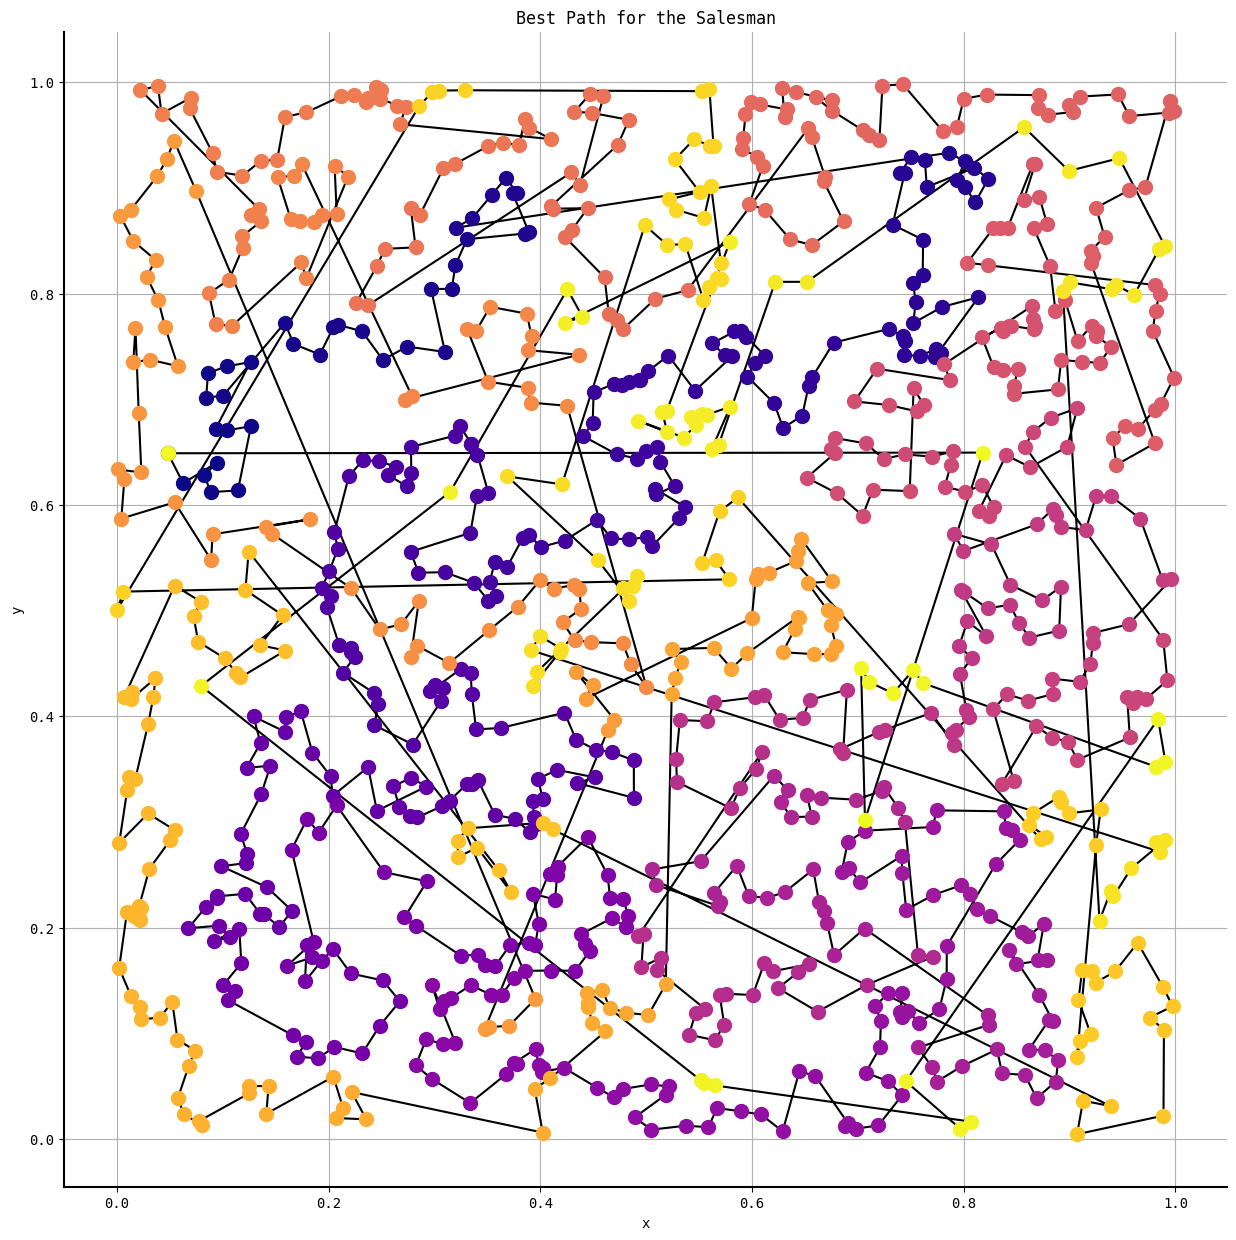

In [54]:
cmap = cm.get_cmap('plasma')
norm = plt.Normalize(0, len(best_path))
plt.figure(figsize=(15, 15))

plt.plot([coordinates[i][0] for i in best_path], [coordinates[i][1] for i in best_path], 'k-')
plt.plot([coordinates[best_path[-1]][0], coordinates[best_path[0]][0]], [coordinates[best_path[-1]][1], coordinates[best_path[0]][1]], 'k-')
for idx, i in enumerate(best_path):
    plt.scatter(coordinates[i][0], coordinates[i][1], color=cmap(norm(idx)), s=100, zorder=5)  # Points with gradient
plt.title('Best Path for the Salesman')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

The graph above shows the optimal path determined by the ACO with 10 ants and 30 iterations. If you take a closer look at the diagram, you will notice that the difference between a few nodes is somewhat large. The question arises as to whether this is really the best way. Well, as with the algorithms above, you can only get close to the optimum solution with ACO. You could certainly achieve better results if you played more with the parameters. The optimization takes much longer the more ants and interations are used. For the purpose of the notebook, however, this is completely sufficient. 


# Conclusion
In this notebook, we explored the Traveling Salesman Problem (TSP) by implementing a variety of algorithms, ranging from exact methods to heuristic approaches. By applying these algorithms to four datasets with an increasing number of cities, we observed how the computational complexity grows with the size of the problem. Initially, we applied brute force and dynamic programming, which provided optimal solutions for smaller datasets. However, as the number of cities increased, the exponential time complexity of these approaches made them impractical for larger instances. The branch and bound method offered some improvements but similarly struggled with scalability as the dataset grew.

To address the limitations of exact methods, we turned to heuristic and metaheuristic algorithms. The nearest neighbor algorithm, while computationally efficient, often produced suboptimal solutions. Genetic algorithms, though more flexible, exhibited variable performance that depended heavily on proper parameter tuning. Christofides' algorithm, on the other hand, provided a reliable approximation, particularly for metric TSP instances, offering a balance between accuracy and efficiency. Finally, ant colony optimization emerged as a powerful metaheuristic, proving effective in balancing solution quality and computation time, especially for larger datasets.

Through this investigation, we observed that while exact algorithms guarantee the optimal solution, heuristic and metaheuristic methods offer a practical compromise between solution quality and computational efficiency as the problem size increases. This study highlights the complexity and challenges of solving the TSP and underscores the importance of choosing the right algorithm based on problem scale and real-world constraints. Ultimately, this exploration deepened our understanding of optimization problems and reinforced the significance of both classical and nature-inspired approaches in tackling NP-hard problems like the TSP.

# Final Words

>Thank you for taking the time to explore this notebook on solving the Traveling Salesman Problem. I hope it has been informative and insightful in demonstrating the different approaches to this classic optimization challenge. If you found this notebook helpful, I would greatly appreciate an upvote or any comments with your feedback or suggestions 👍